# Langgraph 2: Graph with Interrupt

In [3]:
#########  LangGraph  ##########################
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

import panel as pn
from typing import TypedDict, Annotated, List, Sequence
from IPython.display import display, Markdown,Latex,Image

# Graph with interrupt

https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787

https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/

This code defines a simple graph-based flow using nodes, states, and transitions between them, with each node performing a specific task in sequence. Here's a breakdown of the code:

### 1. **State Definition**

   ```python
   class State(TypedDict):
       input: str
       messages: Annotated[list, add_messages]
   ```
   - `State` is a custom data structure using `TypedDict` to define the types of state properties.
   - It has two fields:
     - `input`: a string input, likely used for carrying initial data.
     - `messages`: a list of messages, annotated for additional behavior, presumably where the flow can accumulate or modify output messages as it progresses through nodes.

### 2. **Node Functions**

   - Each node function (`node1`, `node2`, `node3`) modifies the `state` and then returns it. Each function performs the following:

     - **`node1`**: Starts by printing "Start node1" and sets `state["messages"]` to `["Output node1: I wanna go home"]`.
     - **`node2`**: Starts by printing "Start node2" and sets `state["messages"]` to `["Output node2: What's the problem with node1?"]`.
     - **`node3`**: Starts by printing "Start node3" and sets `state["messages"]` to `["node3: I am going home"]`.

   - Each node is designed to sequentially alter `state["messages"]` with a unique message.

### 3. **StateGraph Creation**

   ```python
   builder = StateGraph(State)
   builder.add_node("node1", node1)
   builder.add_node("node2", node2)
   builder.add_node("node3", node3)
   builder.set_entry_point("node1")
   ```
   - `StateGraph` is initialized with the `State` structure, which defines the state format that each node will manipulate.
   - Nodes `node1`, `node2`, and `node3` are added to the graph with corresponding functions.
   - `set_entry_point("node1")` designates `node1` as the starting point of the graph.

### 4. **Defining the Flow (Edges)**

   ```python
   builder.add_edge("node1", "node2")
   builder.add_edge("node2", "node3")
   builder.add_edge("node3", END)
   ```
   - These edges define the sequence in which nodes execute:
     - After `node1`, the flow proceeds to `node2`.
     - After `node2`, it moves to `node3`.
     - After `node3`, the process ends (`END`).

### 5. **Memory Setup and Graph Compilation**

   ```python
   memory = MemorySaver()
   graph = builder.compile(checkpointer=memory, interrupt_before=["node3"])
   ```
   - `MemorySaver()` is set up to track the state across the nodes, storing each step in memory.
   - `interrupt_before=["node3"]` indicates an interruption before `node3` executes, perhaps to review or change the state.

### 6. **Visualization of the Graph**

   ```python
   display(Image(graph.get_graph().draw_mermaid_png()))
   ```
   - Finally, the code generates and displays a graphical representation of the flow using `Mermaid` notation. Each node and edge of the graph will be displayed, showing how the flow progresses from `node1` to `node2` to `node3`.

### Summary

This code builds a simple stateful flow where:
- **Each node** changes the `state["messages"]`.
- **Flow** goes from `node1` ➔ `node2` ➔ `node3`.
- **Memory and interruption** allow state tracking and intervention before the final node.
- **Graph visualization** shows the flow for easier comprehension and debugging. 

This setup can be particularly useful in chatbot flows, decision trees, or automated process orchestration scenarios where states change sequentially through nodes.

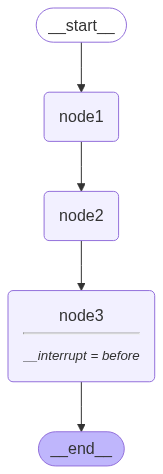

In [4]:
class State(TypedDict):
    input: str
    messages: Annotated[list, add_messages]


def node1(state:State):
    latest_message = state["messages"][-1] if state["messages"] else "No messages"
    print(f"Start node1 with latest message: {latest_message}")
    return {'messages' : "Output node1: I go home" }


def node2(state:State):
    latest_message = state["messages"][-1] if state["messages"] else "No messages"
    print(f"Start node2 with latest message: {latest_message}")
    state["messages"]=["Output node2: What's the problem with node1?"]
    return state 



def node3(state:State):
    latest_message = state["messages"][-1] if state["messages"] else "No messages"
    print(f"Start node3 with latest message: {latest_message}")
    state["messages"]=["node3: I am going home"]
    return state 



builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.set_entry_point("node1") 
builder.add_edge("node1", "node2")
builder.add_edge("node2", "node3")
builder.add_edge("node3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory,interrupt_before=["node3"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## The graph is executed up to node 2.

Note:

1. `initial_input` is passed to `state` before the start of `node1`.

2. The `state` list is populated with the messages from the nodes.

3. The graph saves the results due to `checkpoint=memory`, meaning if you run the graph again, the previous list will continue.

In [7]:
thread = {"configurable": {"thread_id": "1"}}
state=State()
initial_input = {"input": "hello world"}
def print_messages(state: State):
    for message in state["messages"]:
        print(message)
for state in graph.stream(initial_input, thread, stream_mode="values"):
    print_messages(state)

Start node 1
content='Output node1: I wanna go home' additional_kwargs={} response_metadata={} id='73c3ce59-5946-42c6-be8e-a20dba2a7bef'
Start node2
content='Output node1: I wanna go home' additional_kwargs={} response_metadata={} id='73c3ce59-5946-42c6-be8e-a20dba2a7bef'
content="Output node2: What's the problem with node1?" additional_kwargs={} response_metadata={} id='fb552208-1a82-4c28-9ccd-bc3018832e04'


In [8]:
print(state)

{'input': 'hello world', 'messages': [HumanMessage(content='Output node1: I wanna go home', additional_kwargs={}, response_metadata={}, id='73c3ce59-5946-42c6-be8e-a20dba2a7bef'), HumanMessage(content="Output node2: What's the problem with node1?", additional_kwargs={}, response_metadata={}, id='fb552208-1a82-4c28-9ccd-bc3018832e04')]}


## Since input=none the graph is continued 

In [6]:
for state in graph.stream(None, thread, stream_mode="values"):
    print(state)    


{'input': 'hello world', 'messages': [HumanMessage(content='Output node1: I wanna go home', additional_kwargs={}, response_metadata={}, id='f2c36ea2-4330-46ce-b0e2-3581d52149bb'), HumanMessage(content="Output node2: What's the problem with node1?", additional_kwargs={}, response_metadata={}, id='097610b9-c9e7-4e81-a814-f188b3e02601')]}
Start node3
{'input': 'hello world', 'messages': [HumanMessage(content='Output node1: I wanna go home', additional_kwargs={}, response_metadata={}, id='f2c36ea2-4330-46ce-b0e2-3581d52149bb'), HumanMessage(content="Output node2: What's the problem with node1?", additional_kwargs={}, response_metadata={}, id='097610b9-c9e7-4e81-a814-f188b3e02601'), HumanMessage(content='node3: I am going home', additional_kwargs={}, response_metadata={}, id='6dd5dc3f-54a1-44fa-b511-cded69c75a9a')]}


## Panel with widget for user input

This code creates an interactive user interface where the user can:

1. Enter a question in the text input field.
2. Click the "Answer" button to submit the input.
3. The input is streamed through a `graph`, and the response is displayed in real time in the output field.

This setup is especially useful for workflows that require real-time feedback, as the input is processed step-by-step through a `graph` structure.

In [9]:
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")  # This will display the answer text

# Function to handle input and update the output

def input_function(event):
    if question.value:
        input = {"input": question.value}
    else:
        input=None
    print("input",input)
    out=[]
    for state in graph.stream(input, thread, stream_mode="values"):
        if state["messages"]:
            out.append(state["messages"][-1].content)
    answer="Hint:graph continues if input is empty! Here are the latest messages"+ "\n".join(out)
    output.object = f"**Answer:**\n\n{answer}"  # Update output with the answer

# Set up the answer button and bind the function
answer_button = pn.widgets.Button(name="Answer", button_type="primary")
answer_button.on_click(input_function)

# Layout with question input, answer button, and output display
Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()


Launching server at http://localhost:33489


input {'input': 'hello again'}
Start node 1
Start node2


In [17]:
state = graph.get_state(thread)
from pprint import pprint
pprint(state.values['messages'])

[HumanMessage(content='Output node1: I wanna go home', additional_kwargs={}, response_metadata={}, id='73c3ce59-5946-42c6-be8e-a20dba2a7bef'),
 HumanMessage(content="Output node2: What's the problem with node1?", additional_kwargs={}, response_metadata={}, id='fb552208-1a82-4c28-9ccd-bc3018832e04'),
 HumanMessage(content='Output node1: I wanna go home', additional_kwargs={}, response_metadata={}, id='4b343eb7-341e-467e-b435-7d79ed473ffc'),
 HumanMessage(content="Output node2: What's the problem with node1?", additional_kwargs={}, response_metadata={}, id='5d7f673a-2301-44f3-8557-b316a2d3ffff')]


### Exercise

a) Run the app so that the graph is executed up to and including node 3.

b) Add the following:

```python
for state in graph.stream(None, thread, stream_mode="values"):
    out.append(state["messages"][-1].content)
```

to continue executing the graph up to node 3.

## Solution

In [ ]:
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")  # This will display the answer text

# Function to handle input and update the output

def input_function(event):
    input = {"input": question.value}

    out=[]

    for state in graph.stream(input, thread, stream_mode="values"):
        if state["messages"]:
            out.append(state["messages"][-1].content)    
        
    for state in graph.stream(None, thread, stream_mode="values"):
        out.append(state["messages"][-1].content)  
       
    print("out",out)    
    answer="Good job " + "\n".join(out)
    output.object = f"**Answer:**\n\n{answer}"  # Update output with the answer

# Set up the answer button and bind the function
answer_button = pn.widgets.Button(name="Answer", button_type="primary")
answer_button.on_click(input_function)

# Layout with question input, answer button, and output display
Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()


Launching server at http://localhost:37687


Start node 1
Start node2
Start node3
out ["Output node2: What's the problem with node1?", 'Output node1: I wanna go home', "Output node2: What's the problem with node1?", "Output node2: What's the problem with node1?", 'node3: I am going home']


Here’s an improved version for clarity and readability:

---

## Same Functionality as Above

However:

- Use `question` as the input for the `input_function`.
- Replace with the `bound` function for binding.



In [7]:

memory = MemorySaver()
graph = builder.compile(checkpointer=memory,interrupt_before=["node3"])


In [ ]:

question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
output = pn.pane.Markdown("Answer")  # This will display the answer text
# Function to handle input and update the output
# memory = MemorySaver()
# graph = builder.compile(checkpointer=memory,interrupt_before=["node3"])
thread = {"configurable": {"thread_id": "3"}}  
def input_function(question:str):
    input = {"input": question}
    out=[]
    for state in graph.stream(input, thread, stream_mode="values"):
        if state["messages"]:
            out.append(state["messages"][-1].content)
    # for state in graph.stream(input, thread, stream_mode="values"):
    #     out.append(state["messages"][-1].content)  
    answer="Graph not continued: "+ "\n".join(out)
    print("input_function",answer)
    return answer

## Widget für die Eingabe
question = pn.widgets.TextInput(name="Input here please", placeholder="Task", sizing_mode="stretch_width")
## Panel für die AUsgabe
output = pn.pane.Markdown("Answer")
answer_button = pn.widgets.Button(name="Answer", button_type="primary", width=50, height=50)

def input2(question:str):
    input = {"input": question}
    out=[]
    for state in graph.stream(input, thread, stream_mode="values"):
        if state["messages"]:
            out.append(state["messages"][-1].content)
    answer="Graph after continuing: "+ "\n".join(out)
    return answer


def button_click(event):
    print(f'number of clicks: {answer_button.clicks}')
    if answer_button.clicks == 1:
        bound_function = pn.bind(input_function, question)
        try:
            result = bound_function()
            output.object = f"Start answer:\n {result}"
        except Exception as e:
             output.object = f"Error in button_click: {e}"
    if answer_button.clicks > 1:
        print(f'restarting because of {answer_button.clicks} clicks')
        bound_function = pn.bind(input2, question)
        output.object = f"Restarting answer:\n {bound_function()}"

answer_button.on_click(button_click)

Tab = pn.Column(
    pn.Row(question),
    pn.panel(answer_button, loading_indicator=True, height=50),
    pn.layout.Divider(),
    pn.panel(output, loading_indicator=True, height=900),
    sizing_mode="stretch_width"
)

layout = pn.Column(pn.Tabs(('Answer', Tab)))
layout.show()


Launching server at http://localhost:34489


number of clicks: 1
Start node1 with latest message: content="Output node2: What's the problem with node1?" additional_kwargs={} response_metadata={} id='014cf963-ac77-47a4-b232-53c81423c553'
Start node2 with latest message: content='Output node1: I go home' additional_kwargs={} response_metadata={} id='88885af9-2209-4e8c-beae-dd4cf21e4a33'
input_function Graph not continued: Output node2: What's the problem with node1?
Output node1: I go home
Output node2: What's the problem with node1?
number of clicks: 2
restarting because of 2 clicks
Start node1 with latest message: content="Output node2: What's the problem with node1?" additional_kwargs={} response_metadata={} id='53875547-e8d1-4b69-9765-7eb0e73283c0'
Start node2 with latest message: content='Output node1: I go home' additional_kwargs={} response_metadata={} id='a55a4fb1-067f-432f-b459-6b04e11ee17e'
input_function Graph not continued: Output node2: What's the problem with node1?
Output node1: I go home
Output node2: What's the pro